In [ ]:
#This code performs the training of the model, and subsequent predictions
#inspired by https://towardsdatascience.com/modeling-dna-sequences-with-pytorch-de28b0a05036


In [1]:

import pandas as pd
import numpy as np
import itertools    
import random    
import math
import gzip

import torch
import torch.nn as nn


import matplotlib.pyplot as plt 
from Bio.Seq import Seq #biopython
import subprocess
from pathlib import Path


In [2]:
torch.cuda.is_available()

True

In [3]:


def rc_on_df(df):
    return(pd.DataFrame({
        "seq":[str(Seq(s).reverse_complement()) for s in df["seq"]],
        "score":df["score"]
    }))

def scoredist(x):
    return math.log10(1+x)

################ Long reads of telomeres
long_fwd = pd.read_pickle("/husky/otherdataset/karimian2024/train50_lin.pickle")[0:500000] #was 2M
long_fwd["score"] = [scoredist(x) for x in long_fwd["score"]]

#Also train on opposite strand
long_rev = rc_on_df(long_fwd)
    
    

all_c = pd.read_pickle("/husky/otherdataset/karimian2024/t2t_centro_50.pickle")
all_nc = pd.read_pickle("/husky/otherdataset/karimian2024/t2t_noncentro_50.pickle")
all_c["score"] = 6  
all_nc["score"] = 10 

################ Middle of genome
n_genome_seqs = 500000
genomeseqs = pd.concat([all_nc[0:n_genome_seqs],all_c[0:n_genome_seqs]])


################ Assemble it all
mer8 = pd.concat([long_fwd, long_rev, genomeseqs, rc_on_df(genomeseqs)])


windowsize=50


In [4]:
kernel_size = 6
kernel_size2 = 6

num_filters = 20
num_filters2 = 20

num_epochs = 200  #200 saturates


def one_hot_encode(seq):
    """
    Given a DNA sequence, return its one-hot encoding
    """
    # Make sure seq has only allowed bases
    allowed = set("ACTGN")
    if not set(seq).issubset(allowed):
        invalid = set(seq) - allowed
        raise ValueError(f"Sequence contains chars not in allowed DNA alphabet (ACGTN): {invalid}")
        
    # Dictionary returning one-hot encoding for each nucleotide 
    nuc_d = {'A':[1.0,0.0,0.0,0.0],
             'C':[0.0,1.0,0.0,0.0],
             'G':[0.0,0.0,1.0,0.0],
             'T':[0.0,0.0,0.0,1.0],
             'N':[0.0,0.0,0.0,0.0]}
    
    # Create array from nucleotide sequence
    vec=np.array([nuc_d[x] for x in seq])
        
    return vec
  


def quick_split(df, split_frac=0.8):
    '''
    Given a df of samples, randomly split indices between
    train and test at the desired fraction
    '''
    cols = df.columns # original columns, use to clean up reindexed cols
    df = df.reset_index()

    # shuffle indices
    idxs = list(range(df.shape[0]))
    random.shuffle(idxs)

    # split shuffled index list by split_frac
    split = int(len(idxs)*split_frac)
    train_idxs = idxs[:split]
    test_idxs = idxs[split:]
    
    # split dfs and return
    train_df = df[df.index.isin(train_idxs)]
    test_df = df[df.index.isin(test_idxs)]
        
    return train_df[cols], test_df[cols]
    
    


from torch.utils.data import Dataset, DataLoader

## Here is a custom defined Dataset object specialized for one-hot encoded DNA:
class SeqDatasetOHE(Dataset):
    '''
    Dataset for one-hot-encoded sequences
    '''
    def __init__(self,
                 df,
                 seq_col='seq',
                 target_col='score'
                ):
        # extract the DNA from the appropriate column in the df
        self.seqs = list(df[seq_col].values)
        self.seq_len = len(self.seqs[0])
        
        # one-hot encode sequences, then stack in a torch tensor
        self.ohe_seqs = torch.stack([torch.tensor(one_hot_encode(x)) for x in self.seqs])
    
        self.labels = torch.tensor(list(df[target_col].values)).unsqueeze(1)
        
    def __len__(self): return len(self.seqs)
    
    def __getitem__(self,idx):
        seq = self.ohe_seqs[idx]
        label = self.labels[idx]
        return seq, label


def build_dataloaders(train_df,
                      test_df,
                      seq_col='seq',
                      target_col='score',
                      batch_size=256,  #was 128
                      shuffle=True
                     ):
    # create Datasets    
    train_ds = SeqDatasetOHE(train_df,seq_col=seq_col,target_col=target_col)
    test_ds = SeqDatasetOHE(test_df,seq_col=seq_col,target_col=target_col)

    # Put DataSets into DataLoaders
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=shuffle)
    test_dl = DataLoader(test_ds, batch_size=batch_size)
    
    return train_dl,test_dl
    


# basic CNN model
class DNA_CNN(nn.Module):
    def __init__(self,
                 seq_len):
        super().__init__()
        self.seq_len = seq_len
        
        self.conv_net = nn.Sequential(
            nn.Conv1d(4, num_filters, kernel_size=kernel_size), # 4 is for the 4 nucleotides
            nn.ReLU(inplace=True),
            nn.Conv1d(num_filters, num_filters2, kernel_size=kernel_size2),
            nn.ReLU(inplace=True),
            nn.Flatten(),
            nn.Linear(num_filters2*(seq_len-kernel_size+1 - kernel_size2+1), 1)
        ) 

    def forward(self, xb):
        # permute to put channel in correct order
        # (batch_size x 4channel x seq_len)
        xb = xb.permute(0,2,1)         

        for layer in self.conv_net:
            xb = layer(xb)
            #print(xb.size())
        return xb

# +--------------------------------+
# | Training and fitting functions |
# +--------------------------------+

def loss_batch(model, loss_func, xb, yb, opt=None,verbose=False):
    '''
    Apply loss function to a batch of inputs. If no optimizer
    is provided, skip the back prop step.
    '''
    # get the batch output from the model given your input batch 
    # ** This is the model's prediction for the y labels! **
    xb_out = model(xb.float())
    
    loss = loss_func(xb_out, yb.float()) # for MSE/regression
    
    if opt is not None: 
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)
    
def train_step(model, train_dl, loss_func, device, opt):
    '''
    Execute 1 set of batched training within an epoch
    '''
    # Set model to Training mode
    model.train()
    tl = [] # train losses
    ns = [] # batch sizes, n
    
    # loop through train DataLoader
    for xb, yb in train_dl:
        # put on GPU
        xb, yb = xb.to(device),yb.to(device)
        
        # provide opt so backprop happens
        t, n = loss_batch(model, loss_func, xb, yb, opt=opt)
        
        # collect train loss and batch sizes
        tl.append(t)
        ns.append(n)
    
    # average the losses over all batches    
    train_loss = np.sum(np.multiply(tl, ns)) / np.sum(ns)
    
    return train_loss

def val_step(model, val_dl, loss_func, device):
    '''
    Execute 1 set of batched validation within an epoch
    '''
    # Set model to Evaluation mode
    model.eval()
    with torch.no_grad():
        vl = [] # val losses
        ns = [] # batch sizes, n
        
        # loop through validation DataLoader
        for xb, yb in val_dl:
            # put on GPU
            xb, yb = xb.to(device),yb.to(device)

            # Do NOT provide opt here, so backprop does not happen
            v, n = loss_batch(model, loss_func, xb, yb)

            # collect val loss and batch sizes
            vl.append(v)
            ns.append(n)

    # average the losses over all batches
    val_loss = np.sum(np.multiply(vl, ns)) / np.sum(ns)
    
    return val_loss
    
def fit(epochs, model, loss_func, opt, train_dl, val_dl,device,patience=1000):
    '''
    Fit the model params to the training data, eval on unseen data.
    Loop for a number of epochs and keep train of train and val losses 
    along the way
    '''
    # keep track of losses
    train_losses = []    
    val_losses = []
    
    # loop through epochs
    for epoch in range(epochs):
        # take a training step
        train_loss = train_step(model,train_dl,loss_func,device,opt)
        train_losses.append(train_loss)

        # take a validation step
        val_loss = val_step(model,val_dl,loss_func,device)
        val_losses.append(val_loss)
        
        print(f"E{epoch} | train loss: {train_loss:.3f} | val loss: {val_loss:.3f}")

    return train_losses, val_losses


def run_model(train_dl,val_dl,model,device,
              lr=0.01, epochs=666, 
              lossf=None,opt=None
             ):
    '''
    Given train and val DataLoaders and a NN model, fit the mode to the training
    data. By default, use MSE loss and an SGD optimizer
    '''
    # define optimizer
    if opt:
        optimizer = opt
    else: # if no opt provided, just use SGD
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    
    # define loss function
    if lossf:
        loss_func = lossf
    else: # if no loss function provided, just use MSE
        loss_func = torch.nn.MSELoss()
    
    # run the training loop
    train_losses, val_losses = fit(
                                epochs, 
                                model, 
                                loss_func, 
                                optimizer, 
                                train_dl, 
                                val_dl, 
                                device)

    return train_losses, val_losses


In [5]:
full_train_df, test_df = quick_split(mer8)
train_df, val_df = quick_split(full_train_df)

print("=========== split data ======== ")

print("Train:", train_df.shape)
print("Val:", val_df.shape)
print("Test:", test_df.shape)


print("=========== build loaders ======== ")
    
train_dl, val_dl = build_dataloaders(train_df, val_df)

=========== split data ======== 
Train: (1920000, 3)
Val: (480000, 3)
Test: (600000, 3)
=========== build loaders ======== 


=========== starting to train ======== 
E0 | train loss: 5.206 | val loss: 4.852
E1 | train loss: 4.787 | val loss: 4.734
E2 | train loss: 4.733 | val loss: 4.678
E3 | train loss: 4.687 | val loss: 4.640
E4 | train loss: 4.646 | val loss: 4.654
E5 | train loss: 4.608 | val loss: 4.572
E6 | train loss: 4.577 | val loss: 4.531
E7 | train loss: 4.550 | val loss: 4.528
E8 | train loss: 4.524 | val loss: 4.619
E9 | train loss: 4.506 | val loss: 4.473
E10 | train loss: 4.489 | val loss: 4.465
E11 | train loss: 4.476 | val loss: 4.457
E12 | train loss: 4.462 | val loss: 4.560
E13 | train loss: 4.452 | val loss: 4.443
E14 | train loss: 4.443 | val loss: 4.421
E15 | train loss: 4.436 | val loss: 4.426
E16 | train loss: 4.427 | val loss: 4.415
E17 | train loss: 4.420 | val loss: 4.411
E18 | train loss: 4.415 | val loss: 4.391
E19 | train loss: 4.409 | val loss: 4.468
E20 | train loss: 4.404 | val loss: 4.415
E21 | train loss: 4.399 | val loss: 4.406
E22 | train loss: 4.395 | val loss: 4.394
E23 

E193 | train loss: 4.259 | val loss: 4.265
E194 | train loss: 4.260 | val loss: 4.270
E195 | train loss: 4.260 | val loss: 4.266
E196 | train loss: 4.261 | val loss: 4.303
E197 | train loss: 4.259 | val loss: 4.270
E198 | train loss: 4.259 | val loss: 4.340
E199 | train loss: 4.260 | val loss: 4.272


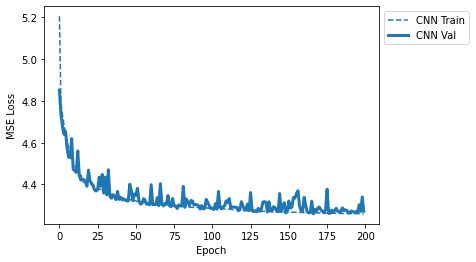

In [6]:
print("=========== starting to train ======== ")

# use GPU if available
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

seq_len = windowsize 

# create Linear model object
model_cnn = DNA_CNN(seq_len)
model_cnn.to(DEVICE) # put on GPU

# run the model with default settings!
cnn_train_losses, cnn_val_losses = run_model(
    train_dl, 
    val_dl, 
    model_cnn,
    DEVICE,
    epochs=num_epochs
)



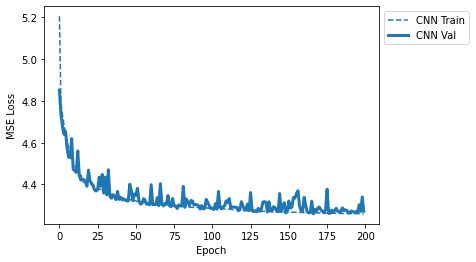

In [16]:
def quick_loss_plot(data_label_list,loss_type="MSE Loss",sparse_n=0):
    '''
    For each train/test loss trajectory, plot loss by epoch
    '''
    for i,(train_data,test_data,label) in enumerate(data_label_list):    
        plt.plot(train_data,linestyle='--',color=f"C{i}", label=f"{label} Train")
        plt.plot(test_data,color=f"C{i}", label=f"{label} Val",linewidth=3.0)

    plt.rcParams['figure.autolayout'] = 'False'
    plt.legend()
    plt.ylabel(loss_type)
    plt.xlabel("Epoch")
    plt.legend(bbox_to_anchor=(1,1),loc='upper left')
    plt.savefig('/home/mahogny/ml_error.svg')
    plt.show()

cnn_data_label = (cnn_train_losses,cnn_val_losses,"CNN")
quick_loss_plot([cnn_data_label])

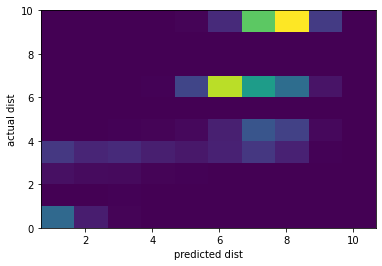

In [17]:
####################
#################### See how predictions ends up
####################

topred = val_df

# one-hot encode sequences, then stack in a torch tensor
ohe_seqs = torch.stack([torch.tensor(one_hot_encode(seq)) for seq in topred["seq"]])

model = model_cnn
model.eval()
with torch.no_grad():
    xb = ohe_seqs.to(DEVICE)
    yb = model(xb.float())
topred["pred"] = yb.cpu().flatten().tolist()
  
plt.hist2d(topred["pred"], topred["score"])
plt.xlabel("predicted dist")
plt.ylabel("actual dist")
plt.show()


In [ ]:
plt.scatter(10**topred["pred"], 10**topred["score"], s=0.3)
plt.xlabel("predicted dist")
plt.ylabel("actual dist")
ax = plt.gca()
ax.set_xlim([0, 60000])
ax.set_ylim([0, 60000])

In [106]:
cutoff = 2
print(
    sum((topred["pred"]<cutoff) & (topred["score"]<cutoff))/topred.shape[0]+
    sum((topred["pred"]>cutoff) & (topred["score"]>cutoff))/topred.shape[0])

0.84385


In [107]:
print(topred['pred'].corr(topred['score']))

0.7433358974704294


In [108]:
topred_sub = topred[topred["score"]>1]
print(topred_sub['pred'].corr(topred_sub['score']))

0.5750851404447265


In [18]:
#model = model_cnn
#model.eval()

torch.save(model, '/husky/otherdataset/karimian2024/model20240421_50bp.pt')


In [123]:
model = torch.load('/husky/otherdataset/karimian2024/model20240421_50bp.pt')
windowsize=50

In [ ]:
################ Run predictions for FASTQ input file;
################ Using PBMC data
################

bam_dir = "/corgi/otherdataset/marquez2020/bam.old"
fname = "/corgi/otherdataset/marquez2020/bam.old/SRR10984461_1.fastq.gzAligned.sortedByCoord.out.bam"

fname_out = "/corgi/otherdataset/marquez2020/loop/pred_subtelo/onepred.csv"

fout = open(fname_out, "wt")


def readMaxLines(proc, num):
    lines=[]
    while True:
        line = proc.stdout.readline()
        if not line:
            break
        line = line.rstrip().decode('ascii')
        lines.append(line)
        if(len(lines)==num):
            break
    return(lines)


proc = subprocess.Popen(['samtools','view',fname],stdout=subprocess.PIPE)
while True:
    lines = readMaxLines(proc, 1000000)
    if len(lines)==0:
        break
    print("read lines:", len(lines))

    seqs = [line.split("\t")[9][0:50] for line in lines]
    #TODO remove lines that are too short, or contain N's
    
    ohe_seqs = torch.stack([torch.tensor(one_hot_encode(seq)) for seq in seqs])

    #model = model_cnn
    model.eval()
    with torch.no_grad():
        xb = ohe_seqs.to(DEVICE)
        yb = model(xb.float())
    pred_dist = yb.cpu().flatten().tolist()
    
    for (seq,n) in zip(seqs,pred_dist):
        #fout.write(str(n)+"\n")
        if n < 1:
            #print(str(seq)+"   "+str(n))
            #fout.write(str(n)+"\n")
            fout.write("_"+seq+","+str(round(n,3))+"\n")
        else:
            fout.write(","+str(n)+"\n")
    
fout.close()

#4 sec/100k reads; 40k/M reads 
#170.553852 M for fibroblast data; 15min to run maybe.



read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 

read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 

read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 100000
read lines: 

In [33]:
################
################ Run predictions for 10x BAM input files
################ (not included in the paper)
################
################

def process_10x_atac(basedir):

    bcfile = str(basedir/"outs"/"filtered_feature_bc_matrix"/"barcodes.tsv.gz")
    bam_fname = str(basedir / "outs" / "atac_possorted_bam.bam")
    outf = str(basedir / "outs" / "atac_possorted_bam.bam.countclassifier.csv")
    print("================================")
    print(bam_fname)


    def readMax10xLines(proc, num, set_bc):
        bcs=[]
        seqs=[]
        while True:
            line = proc.stdout.readline()
            if not line:
                break
            line = line.rstrip().decode('ascii')
            lineparts = line.split("\t")

            this_seq = lineparts[9]

            i=line.find("CB:Z:")
            if i!=-1 & len(this_seq) >= windowsize:
                this_bc = line[(i+5):(i+23)]
                if this_bc in set_bc:
                    #print(this_bc)
                    bcs.append(this_bc)
                    seqs.append(this_seq[0:windowsize])
                    if len(seqs)==num:
                        break
        return((bcs,seqs))


    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    seq_len = windowsize #  len(train_df['seq'].values[0])
    model_cnn = DNA_CNN(seq_len)
    model_cnn.to(DEVICE) # put on GPU

    def open_gzip_optional(fname,mode="rt"):
            if fname.endswith("gz"):
                    return gzip.open(fname,mode)
            elif fname.endswith("bz2"):
                    return bz2.open(fname,mode)
            else:
                    return open(fname,mode)

    ### Read which barcodes to extract
    with open_gzip_optional(bcfile) as file:
        bcs = [line.rstrip() for line in file]
    count_dict = set(bcs)

    ## Empty count matrix
    import numpy as np
    #map_cnt_i = [str(x/10) for x in range(10,290)]
    map_cb_i = dict(zip(bcs,range(len(bcs))))
    #cntmat = np.empty([len(map_cnt_i), len(map_cb_i)])
    cntmat_rows = bcs
    cntmat_cols = [str(n/10) for n in range(0,100)]
    cntmat = np.array([[0]*len(cntmat_cols)]*len(map_cb_i), dtype=int)

    max_bin = cntmat.shape[1]-1

    #samtools view -f 4 file.bam
    #-f is to get; -F to remove

    print("running over "+bam_fname)
    proc = subprocess.Popen(['samtools','view',bam_fname],stdout=subprocess.PIPE)
    curlines=0
    while True:
        (current_bcs,seqs) = readMax10xLines(proc, 100000, count_dict)
        if len(current_bcs)==0:
            break
        curlines = curlines + len(current_bcs)

        last_seqs = seqs #for debugging

        if curlines>=0:
            ohe_seqs = torch.stack([torch.tensor(one_hot_encode(seq)) for seq in seqs])

            model.eval()
            with torch.no_grad():
                xb = ohe_seqs.to(DEVICE)
                yb = model(xb.float())
            pred_dist = yb.cpu().flatten().tolist()

            for (bc,n) in zip(current_bcs,pred_dist):
                cntbin = int(n*10)
                #print(n)
                if cntbin<0:
                    cntbin=0
                if cntbin>max_bin:
                    cntbin=max_bin

                #Figure out which 
                cbi = map_cb_i[bc]        
                cntmat[cbi, cntbin] = cntmat[cbi, cntbin]+1
            #break

        if (curlines%1000000)==0:
            print(curlines)
            #print(seqs)
            #break


    pd_cntmat = pd.DataFrame(data=cntmat,index=cntmat_rows,     columns=cntmat_cols) 
    pd_cntmat.to_csv(outf)
    print("done")

In [ ]:
#basedir = Path("/corgi/cellbuster/fibro2022/cellranger-arc/lib3")
#basedir = Path("/corgi/cellbuster/fibro2022/cellranger-arc/lib4")
process_10x_atac(Path('/corgi/cellbuster/fibro2022/cellranger-arc/lib3'))



In [35]:

process_10x_atac(Path('/corgi/cellbuster/10xpbmc/cellranger-arc/10k_PBMC_Multiome_nextgem_Chromium_Controller'))
process_10x_atac(Path('/corgi/cellbuster/10xpbmc/cellranger-arc/10k_PBMC_Multiome_nextgem_Chromium_X'))
process_10x_atac(Path('/corgi/cellbuster/10xpbmc/cellranger-arc/pbmc_granulocyte_sorted_10k'))
process_10x_atac(Path('/corgi/cellbuster/10xpbmc/cellranger-arc/pbmc_granulocyte_unsorted_10k'))


/corgi/cellbuster/10xpbmc/cellranger-arc/10k_PBMC_Multiome_nextgem_Chromium_Controller/outs/atac_possorted_bam.bam
running over /corgi/cellbuster/10xpbmc/cellranger-arc/10k_PBMC_Multiome_nextgem_Chromium_Controller/outs/atac_possorted_bam.bam
1000000
2000000
3000000
4000000
5000000
6000000
7000000
8000000
9000000
10000000
11000000
12000000
13000000
14000000
15000000
16000000
17000000
18000000
19000000
20000000
21000000
22000000
23000000
24000000
25000000
26000000
27000000
28000000
29000000
30000000
31000000
32000000
33000000
34000000
35000000
36000000
37000000
38000000
39000000
40000000
41000000
42000000
43000000
44000000
45000000
46000000
47000000
48000000
49000000
50000000
51000000
52000000
53000000
54000000
55000000
56000000
57000000
58000000
59000000
60000000
61000000
62000000
63000000
64000000
65000000
66000000
67000000
68000000
69000000
70000000
71000000
72000000
73000000
74000000
75000000
76000000
77000000
78000000
79000000
80000000
81000000
82000000
83000000
84000000
85000000
8

112000000
113000000
114000000
115000000
116000000
117000000
118000000
119000000
120000000
121000000
122000000
123000000
124000000
125000000
126000000
127000000
128000000
129000000
130000000
131000000
132000000
133000000
134000000
135000000
136000000
137000000
138000000
139000000
140000000
141000000
142000000
143000000
144000000
145000000
146000000
147000000
148000000
149000000
150000000
151000000
152000000
153000000
154000000
155000000
156000000
157000000
158000000
159000000
160000000
161000000
162000000
163000000
164000000
165000000
166000000
167000000
168000000
169000000
170000000
171000000
172000000
173000000
174000000
175000000
176000000
177000000
178000000
179000000
180000000
181000000
182000000
183000000
184000000
185000000
186000000
187000000
188000000
189000000
190000000
191000000
192000000
193000000
194000000
195000000
196000000
197000000
198000000
199000000
200000000
201000000
202000000
203000000
204000000
205000000
206000000
207000000
208000000
209000000
210000000
211000000


FileNotFoundError: [Errno 2] No such file or directory: '/corgi/cellbuster/10xpbmc/cellranger-arc/pbmc_granulocyte_unsorted_10k/outs/filtered_feature_bc_matrix/barcodes.tsv.gz'

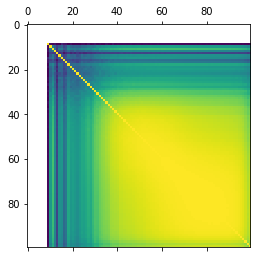

In [26]:
import matplotlib.pyplot as plt
plt.matshow(pd_cntmat.corr()) ##note, no depth normalization done here
plt.show()


In [37]:

process_10x_atac(Path('/corgi/cellbuster/bigt/cellranger-arc/lib6'))
process_10x_atac(Path('/corgi/cellbuster/bigt/cellranger-arc/lib7'))
process_10x_atac(Path('/corgi/cellbuster/bigt/cellranger-arc/lib8'))
process_10x_atac(Path('/corgi/cellbuster/bigt/cellranger-arc/lib9'))



/corgi/cellbuster/bigt/cellranger-arc/lib6/outs/atac_possorted_bam.bam
running over /corgi/cellbuster/bigt/cellranger-arc/lib6/outs/atac_possorted_bam.bam
1000000
2000000
3000000
4000000
5000000
6000000
7000000
8000000
9000000
10000000
11000000
12000000
13000000
14000000
15000000
16000000
17000000
18000000
19000000
20000000
21000000
22000000
23000000
24000000
25000000
26000000
27000000
28000000
29000000
30000000
31000000
32000000
33000000
34000000
35000000
36000000
37000000
38000000
39000000
40000000
41000000
42000000
43000000
44000000
45000000
46000000
47000000
48000000
49000000
50000000
51000000
52000000
53000000
54000000
55000000
56000000
57000000
58000000
59000000
60000000
61000000
62000000
63000000
64000000
65000000
66000000
67000000
68000000
69000000
70000000
71000000
72000000
73000000
74000000
75000000
76000000
77000000
78000000
79000000
80000000
81000000
82000000
83000000
84000000
85000000
86000000
87000000
88000000
89000000
90000000
91000000
92000000
93000000
94000000
95000000

In [36]:

process_10x_atac(Path('/corgi/cellbuster/bigb/cellranger-arc/lib1'))
process_10x_atac(Path('/corgi/cellbuster/bigb/cellranger-arc/lib2'))
process_10x_atac(Path('/corgi/cellbuster/bigb/cellranger-arc/lib3'))
process_10x_atac(Path('/corgi/cellbuster/bigb/cellranger-arc/lib4'))



/corgi/cellbuster/bigb/cellranger-arc/lib1/outs/atac_possorted_bam.bam
running over /corgi/cellbuster/bigb/cellranger-arc/lib1/outs/atac_possorted_bam.bam
1000000
2000000
3000000
4000000
5000000
6000000
7000000
8000000
9000000
10000000
11000000
12000000
13000000
17000000
18000000
19000000
20000000
21000000
22000000
23000000
24000000
25000000
26000000
27000000
28000000
29000000
30000000
31000000
32000000
33000000
34000000
35000000
36000000
37000000
38000000
39000000
40000000
41000000
42000000
43000000
44000000
45000000
46000000
47000000
48000000
49000000
50000000
51000000
52000000
53000000
54000000
55000000
56000000
57000000
58000000
59000000
60000000
61000000
62000000
63000000
64000000
65000000
66000000
67000000
68000000
69000000
70000000
71000000
72000000
73000000
74000000
75000000
76000000
77000000
78000000
79000000
80000000
81000000
82000000
83000000
84000000
85000000
86000000
87000000
88000000
89000000
90000000
91000000
92000000
93000000
94000000
95000000
96000000
97000000
98000000